# Week 3: Transfer Learning

Welcome to this assignment! This week, you are going to use a technique called `Transfer Learning` in which you utilize an already trained network to help you solve a similar problem to the one it was originally trained to solve.

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- ou can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import unittests

## Dataset

For this assignment, you will use the `Horse or Human dataset`, which contains images of horses and humans. 

All the images are contained within the `./data/` directory. The complete tree looks like this:
```
.
└── data/
    ├── train/
    │   ├── horses/
    │   │   ├── train_horse_1.png
    │   │   └── ...
    │   └── humans/
    │       ├── train_human_1.png
    │       └── ...
    └── validation/
        ├── horses/
        │   ├── val_horse_1.png
        │   └── ...
        └── humans/
            ├── val_human_1.png
            └── ...
```

In [3]:
TRAIN_DIR = './data/train/'
VALIDATION_DIR = './data/validation/'

Now take a look at a sample image of each one of the classes. You will simply be picking the first image from each class in the `train` folder.

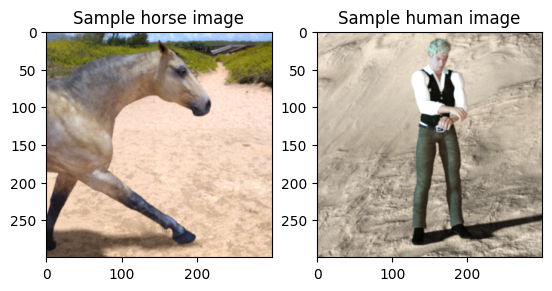

In [4]:
# Directories for each class
horses_dir = os.path.join(TRAIN_DIR, 'horses')
humans_dir = os.path.join(TRAIN_DIR, 'humans')

# Load the first example of each one of the classes
sample_image_horse  = tf.keras.preprocessing.image.load_img(os.path.join(horses_dir, os.listdir(horses_dir)[0]))
sample_image_human  = tf.keras.preprocessing.image.load_img(os.path.join(humans_dir, os.listdir(humans_dir)[0]))

ax = plt.subplot(1,2,1)
ax.imshow(sample_image_horse)
ax.set_title('Sample horse image')

ax = plt.subplot(1,2,2)
ax.imshow(sample_image_human)
ax.set_title('Sample human image')
plt.show()

By plotting the images with `matplotlib` it is easy to see that these images have a resolution of 300x300 (look at the image axes) and are colored, but you can double check this by using the code below:

In [5]:
# Convert the image into its numpy array representation
sample_array = tf.keras.preprocessing.image.img_to_array(sample_image_horse)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


As expected, the sample image has a resolution of 300x300 and the last dimension is used for each one of the RGB channels to represent color.

## Exercise 1: train_val_datasets
Now that you have a better understanding of the images you are dealing with, it is time for you to code the datsets that will feed these images to your network. For this, complete the `train_val_datasets` function below, in which you will be using the [`image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function from `tf.keras.utils`. For grading purposes, use a batch size of 32 for the generators, you can later test what happens if you change this parameter.

**Important Note:** The images have a resolution of 300x300 but the `image_dataset_from_directory` method you will use allows you to set a target resolution. In this case, **set a `image_size` of (150, 150)**. This will heavily lower the number of trainable parameters in your final network, yielding much quicker training times without compromising the accuracy! 


In [8]:
# GRADED FUNCTION: train_val_datasets

def train_val_datasets():
    """Creates training and validation datasets

    Returns:
        (tf.data.Dataset, tf.data.Dataset): training and validation datasets
    """

    ### START CODE HERE ###

    training_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=TRAIN_DIR,
        batch_size=32,
        image_size=(150, 150),
        shuffle=True, 
        seed=7 
    ) 
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=VALIDATION_DIR,
        batch_size=32,
        image_size=(150, 150),
        shuffle=True, 
        seed=7 
    )  

    ### END CODE HERE ###
                                                                        
    return training_dataset, validation_dataset

In [9]:
# Test your generators
training_dataset, validation_dataset = train_val_datasets()

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


**Expected Output:**
```
Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
```

In [10]:
# Test your code!
unittests.test_train_val_datasets(train_val_datasets)

 All tests passed!


Ultimately, you will want to use your trained model to predict new images, so it is always good to reserve some images for the test set. This will be images never seen by the model, which you can use to check your final model performance. As the original dataset doesn't contain a test set, you will create one by splitting the validation dataset.

In [11]:
val_batches = int(validation_dataset.cardinality())
test_dataset, validation_dataset = tf.keras.utils.split_dataset(validation_dataset, val_batches//5)

print(f'Number of validation batches: {validation_dataset.cardinality()}')
print(f'Number of test batches: {test_dataset.cardinality()}')

Number of validation batches: 7
Number of test batches: 1


## Exercise 2: create_pre_trained_model

For this assignment, you will be using the pretrained model `inception V3` available on Tensorflow. In the `model` folder, you can already find the `inception V3` weights, so you can use them to initialize the [`InceptionV3`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3) model.

In [12]:
# Define the path to the inception v3 weights
LOCAL_WEIGHTS_FILE = './model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

Complete the `create_pre_trained_model` function below. You should specify the correct `input_shape` for the model (remember that you set a new resolution for the images instead of the native 300x300). Remember to make all of the layers non-trainable, since you will be using the weights you just downloaded.

In [13]:
# GRADED FUNCTION: create_pre_trained_model

def create_pre_trained_model():
    """Creates the pretrained inception V3 model

    Returns:
        tf.keras.Model: pre-trained model
    """

    ### START CODE HERE ###
    
    pre_trained_model = tf.keras.applications.inception_v3.InceptionV3( 
        include_top=False, 
        input_shape=(150, 150, 3),
        weights='imagenet'
    ) 

    # Make all the layers in the pre-trained model non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False

    ### END CODE HERE ###

    return pre_trained_model

In [14]:
# Create the pre-trained model
pre_trained_model = create_pre_trained_model()

# Count the total number of parameters and how many are trainable
num_total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {num_total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


**Expected Output:**
```
There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.
```

In [15]:
# Test your code!
unittests.test_create_pre_trained_model(create_pre_trained_model)

 All tests passed!


Now print the summary for the `pre_trained_model`. If you scroll down to the end of your output you will see that the layers in the model are set to non-trainable, since the number of `Total params` is the same as `Non-trainable params`. 

In [16]:
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

## Creating callbacks for later
You do not want your model to train more than it is necessary, so you will be creating a callback to stop the training once an accuracy of 99.9% is reached. Since you have already worked with callbacks beforehand in this specialization, this callback is provided for you, just run the cell below. 

In [17]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.999:
            self.model.stop_training = True
            print("\nReached 99.9% accuracy so cancelling training!")

## Exercise 3: output_of_last_layer
Now that the pre-trained model is ready, you need to "glue" it to your own model to solve the task at hand. For this you will need the last output of the pre-trained model, since this will be the input for your own. Complete the `output_of_last_layer` function below.

**Note:** For grading purposes use the `mixed7` layer as the last layer of the pre-trained model. However, after submitting feel free to come back here and play around with this.

In [18]:
# GRADED FUNCTION: output_of_last_layer

def output_of_last_layer(pre_trained_model):
    """Fetches the output of the last desired layer of the pre-trained model

    Args:
        pre_trained_model (tf.keras.Model): pre-trained model

    Returns:
        tf.keras.KerasTensor: last desired layer of pretrained model
    """
    ### START CODE HERE ###

    last_desired_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_desired_layer.output
    
    print('last layer output shape: ', last_output.shape)
    
    ### END CODE HERE ###

    return last_output

Check that everything works as expected:

In [19]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)


**Expected Output (if `mixed7` layer was used):**

```
last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")
```

In [20]:
# Test your code!
unittests.test_output_of_last_layer(output_of_last_layer, pre_trained_model)

 All tests passed!


Now you will create the final model by adding some additional layers on top of the pre-trained model.

Complete the `create_final_model` function below. You will need to use Tensorflow's [Functional API](https://www.tensorflow.org/guide/keras/functional) for this since the pretrained model has been created using it. 

Let's double check this first:

In [21]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.models.functional.Functional'>


## Exercise 4: create_final_model

To create the final model, you will use tf.keras.Model class by defining the appropriate inputs and outputs. If you need any help doing this, you can check the official [docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

There is more than one way to implement the final layer for this kind of binary classification problem. **For this exercise, use a layer with a single unit and a sigmoid activation function along with an appropriate loss function**. This way the number of parameters to train is consistent with the expected outputs presented later.

To help you build the full model, remember that you can get the input from any existing model by using its `input` attribute and by using the Funcional API you can use the last layer directly as output when creating the final model.

In [22]:
# GRADED FUNCTION: create_final_model

def create_final_model(pre_trained_model, last_output):
    """Creates final model by adding layers on top of the pretrained model.

    Args:
        pre_trained_model (tf.keras.Model): pre-trained inceptionV3 model
        last_output (tf.keras.KerasTensor): last layer of the pretrained model

    Returns:
        Tensorflow model: final model
    """
    
    # Flatten the output layer of the pretrained model to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)

    ### START CODE HERE ###

    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = tf.keras.layers.Dropout(0.2)(x)  
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)        

    # Create the complete model by using the Model class
    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

    # Compile the model
    model.compile( 
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), 
        loss='binary_crossentropy', # use a loss for binary classification
        metrics=['accuracy'] 
    )

    ### END CODE HERE ###
  
    return model

In [23]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


**Expected Output:**
```
There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.
```

Wow, that is a lot of parameters!

After submitting your assignment later, try re-running this notebook but using the original resolution of 300x300, you will be surprised to see how many more parameters there are for that case.

In [24]:
# Test your code!
unittests.test_create_final_model(create_final_model, pre_trained_model, last_output)

I0000 00:00:1733203210.996532     283 service.cc:145] XLA service 0x710a08003610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733203210.996657     283 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6


 All tests passed!


I0000 00:00:1733203215.230537     283 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Before training the model, there is one small preprocessing you need to apply to the input images. According to the `inception_v3` [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3), the model expects you to apply [`tf.keras.applications.inception_v3.preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) to the images, which simply scales the input pixels between 1 and -1. Run the cell below to define a `preprocess` function, which you can then apply to the data.

In [25]:
# Define the preprocess function
def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

# Apply the preprocessing to all datasets
training_dataset = training_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

Now that you have defined your model and the preprocessing function, go ahead and train it. Note the `map` method used to apply the preprocessing to the train, validation and test datasets.

In [26]:
# Run this and see how many epochs it takes before the callback fires
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 100,
    verbose = 2,
    callbacks = [EarlyStoppingCallback()],
)

Epoch 1/100
33/33 - 17s - 516ms/step - accuracy: 0.9708 - loss: 0.1282 - val_accuracy: 0.9732 - val_loss: 0.0778
Epoch 2/100
33/33 - 2s - 73ms/step - accuracy: 0.9971 - loss: 0.0171 - val_accuracy: 0.9866 - val_loss: 0.0447
Epoch 3/100

Reached 99.9% accuracy so cancelling training!
33/33 - 2s - 73ms/step - accuracy: 0.9990 - loss: 0.0072 - val_accuracy: 0.9911 - val_loss: 0.0382


The training should have stopped after less than 5 epochs and it should have reached an accuracy over 99,9% (firing the callback). This happened so quickly because of the pre-trained model you used, which already contained information to classify humans from horses. Really cool!

Now take a quick look at the training and validation accuracies for each epoch of training. Of course, since the training was done so fast you will not have many points to visualize.

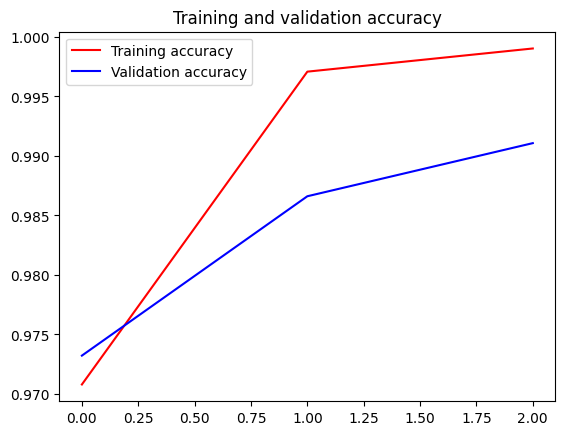

In [27]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

## Testing your model
Now that you have trained your full model, you can go ahead and test the performance on the test data you created earlier. You can simply use the `.evaluate` method for this purpose:

In [28]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test loss: {test_loss},\nTest accuracy: {test_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0150
Test loss: 0.014997921884059906,
Test accuracy: 1.0


**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that leverages a pre-trained network to help you solve the problem of classifying humans from horses.

**Keep it up!**